In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

Importing plotly failed. Interactive plots will not work.


# Previsão do número de casos de COVID no Espírito Santo

In [2]:
df_casos_es_completa = pd.read_csv('C:/Users/Gabriel/Desktop/Projeto_M3//Dados_limpos/casos_full_es_limpa.csv', sep=',')
df_casos_es_completa['date'] = pd.to_datetime(df_casos_es_completa['date'],format='%Y-%m-%d')


In [3]:
#Criação do dataframe para utilização do fb prophet
previsao_casos = pd.DataFrame()
previsao_casos['ds'] = df_casos_es_completa['date'][:430]
previsao_casos['y'] = df_casos_es_completa['new_confirmed'][:430]
#Utilizando 430 primeiros dias

In [4]:
#Criação do modelo, e da previsao com outliers

modelo = Prophet(changepoint_range=0.9, changepoint_prior_scale=0.05, seasonality_mode='multiplicative',  weekly_seasonality=7)
modelo.add_country_holidays(country_name='BR')
modelo.fit(previsao_casos)
datafranefuturo = modelo.make_future_dataframe(periods=15)
previsao = modelo.predict(datafranefuturo)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [5]:
#Criação do dataframe de treino
df_teste_casos = pd.DataFrame()
df_teste_casos['ds'] = df_casos_es_completa['date'][430:]
df_teste_casos['y'] = df_casos_es_completa['new_confirmed'][430:]

In [6]:
#remoção de outliers
previsao_casos_novo = previsao_casos.reset_index()
sem_ouliers = previsao_casos_novo[ (previsao_casos_novo['y'] > previsao['yhat_lower'][:430]) & (previsao_casos_novo['y'] < previsao['yhat_upper'][:430])]

In [7]:
#Criação do modelo, e da previsao sem outliers

modelo = Prophet(changepoint_range=0.9, changepoint_prior_scale=0.05, seasonality_mode='multiplicative',  weekly_seasonality=7)
modelo.add_country_holidays(country_name='BR')
modelo.fit(sem_ouliers)
datafranefuturo = modelo.make_future_dataframe(periods=60)
previsao = modelo.predict(datafranefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Obs: A inclusão de testes a posteriori, com a inclusão de mcmc, além de aumentar gigantescamente a necessidade de processamento não criou qualquer melhora significativa no modelo. 

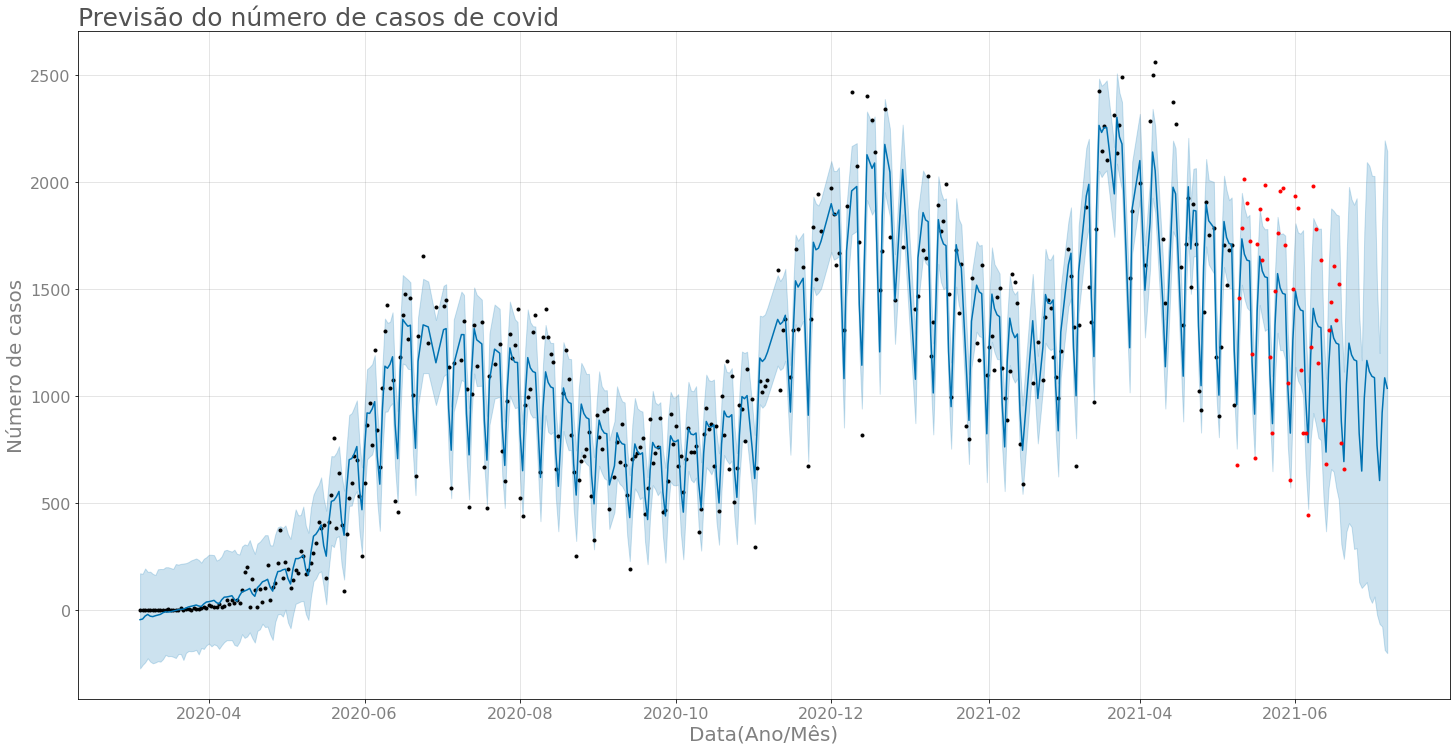

In [8]:
modelo.plot(previsao, xlabel='DataAplicacao', ylabel= 'ES', figsize=(20,10)); 
plt.plot(df_teste_casos['ds'], df_teste_casos['y'], '.r')

plt.title('Previsão do número de casos de covid', loc = 'left', fontsize = 25, color = '#525252')
plt.xticks(fontsize=16, rotation=360, color='#808080')
plt.yticks(fontsize=16, color='#808080')
plt.xlabel('Data(Ano/Mês)', fontsize=20, color='#808080')
plt.ylabel('Número de casos', fontsize=20, color='#808080')
plt.show()

Assim como prever os óbitos, prever o número de casos é uma tarefa árdua por diversos motivos. Além disso, a sazonalidade observada semanalmente não é um evento natural, mas sim uma situação artificial de represamento de dados. 

Outro ponto importante, a taxa de transmissão da doença é a chave para um modelo eficiente de previsão, e infelizmente não foi possível trabalhar com esse valor.

O Prophet embora muito poderoso pode recorrer a erros. Como os dados de casos se comportam de forma muito irregular durante o ano, mais ou menos amostras para teste podem influenciar gigantescamente o comportamento da previsão futura. 

Ou seja, uma previsão robusta de casos de covid demanda de muito mais informações e depende de muitos fatores externos, sendo a previsão desenvolvida aqui apenas um indicativo do que pode acontecer nas próximas semanas com a manutenção da pandemia nos níveis de transmissão e tratamento atuais. 


## Cross validation

In [9]:
df_cv = cross_validation(modelo, initial='220 days', period='15 days', horizon = '30 days')

INFO:prophet:Making 12 forecasts with cutoffs between 2020-10-25 00:00:00 and 2021-04-08 00:00:00


In [10]:
df_cv['cutoff'].unique()

array(['2020-10-25T00:00:00.000000000', '2020-11-09T00:00:00.000000000',
       '2020-11-24T00:00:00.000000000', '2020-12-09T00:00:00.000000000',
       '2020-12-24T00:00:00.000000000', '2021-01-08T00:00:00.000000000',
       '2021-01-23T00:00:00.000000000', '2021-02-07T00:00:00.000000000',
       '2021-02-22T00:00:00.000000000', '2021-03-09T00:00:00.000000000',
       '2021-03-24T00:00:00.000000000', '2021-04-08T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [11]:
janela = 5

cutoff = df_cv['cutoff'].unique()[janela]
df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]

Text(0.5, 0, 'ds')

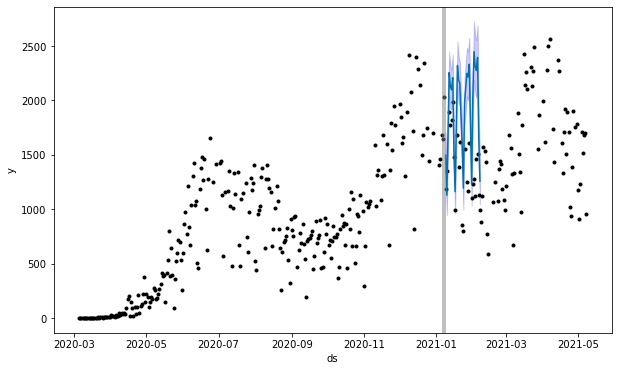

In [12]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(modelo.history['ds'].values, modelo.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                df_cv_cut['yhat_upper'], color='blue',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

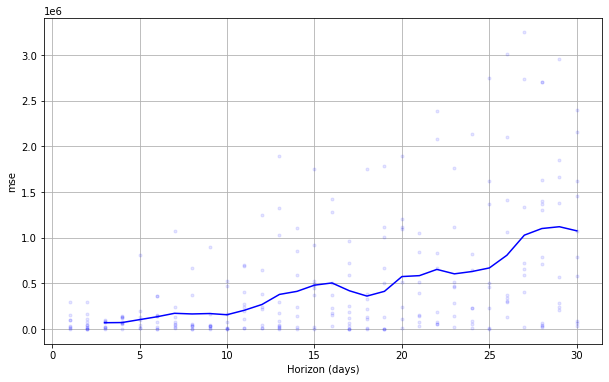

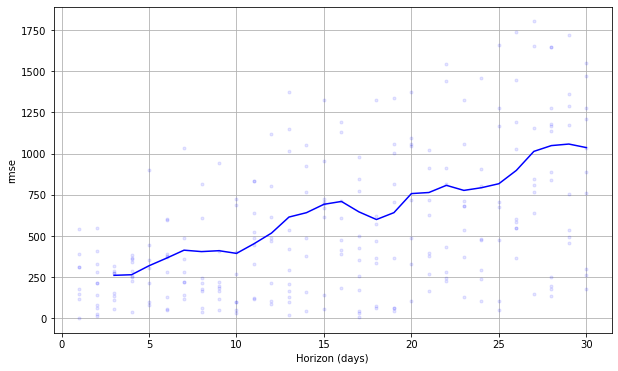

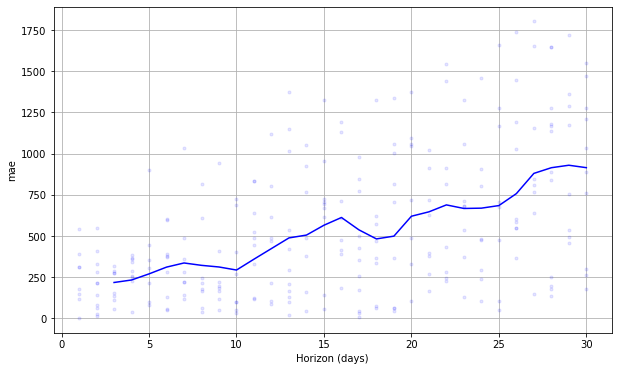

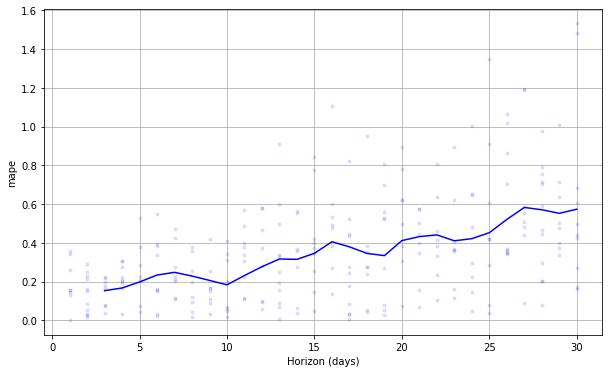

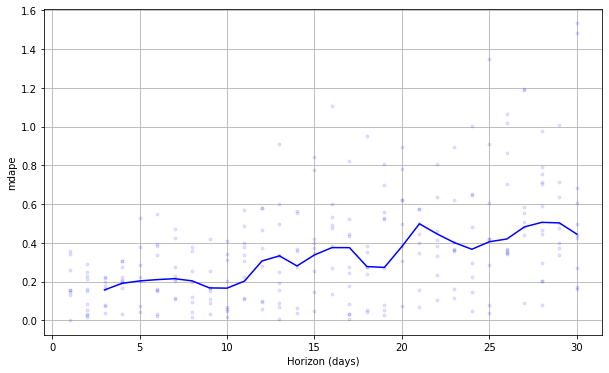

In [13]:
plot_cross_validation_metric(df_cv, metric='mse'); 
plot_cross_validation_metric(df_cv,metric='rmse') 
plot_cross_validation_metric(df_cv, metric='mae'); 
plot_cross_validation_metric(df_cv, metric='mape');
plot_cross_validation_metric(df_cv, metric='mdape');

A validação demonstra o aumento do erro com o passar do tempo. Mas assim como na previsão de óbitos, demonstra que o modelo é eficiente para um curto período de tempo.